# Central Bank Policy Rates - BIS

## Python set-up

In [30]:
# system imports
from pathlib import Path

In [70]:
# analytic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry

In [32]:
# local imports
from plotting import (
    finalise_plot,
    set_chart_dir,
    plot_series_highlighted,
    line_plot,
)

In [66]:
# plotting set-up
SOURCE = "Source: BIS policy rates"
LFOOTER = "Daily data.  Note: There are lags in BIS data reporting. "
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/BIS/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
set_chart_dir(CHART_DIR)
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()
SHOW = False

## Data capture

In [72]:
def country_code_to_name(country_code: str) -> str:
    """Convert 2-digit country codes to country names."""

    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name
    except AttributeError:
        if country_code == "XM":
            return "Euro Area"
        return country_code

In [79]:
def get_bis_data(start="2018-01-01") -> tuple[pd.DataFrame, str]:
    """Get central bank policy rates from the BIS for a select set of states.
    Arguments: start -- the start date for the data (default: 2018-01-01)
    Returns a DataFrame of daily data and a string of the latest rates."""

    states = ["AU", "CA", "GB", "JP", "NO", "KR", "NZ", "SE", "US", "XM"]
    box = {}
    finals = []
    for abbr in states:
        state = country_code_to_name(abbr)
        print(state)
        url = f"https://stats.bis.org/api/v2/data/dataflow/BIS/WS_CBPOL/1.0/D.{abbr}?startPeriod={start}&format=csv"
        df = pd.read_csv(url)[["TIME_PERIOD", "OBS_VALUE"]]
        s = pd.Series(
            df["OBS_VALUE"].values,
            name=state,
            dtype=float,
            index=pd.to_datetime(df["TIME_PERIOD"]),
        )
        idx = pd.date_range(start=s.index.min(), end=s.index.max(), freq="D")
        s = s.reindex(idx, fill_value=np.nan)
        s = s.sort_index()
        s = s.ffill()
        box[state] = s
        finals.append(f"{abbr}: {s.iloc[-1]:.2f}")
    data = pd.DataFrame(box)
    data.index = pd.PeriodIndex(data.index, freq="D")

    return data, ", ".join(finals)


df, latest_rates = get_bis_data()

Australia
Canada
United Kingdom
Japan
Norway
Korea, Republic of
New Zealand
Sweden
United States
Euro Area


## Plotting

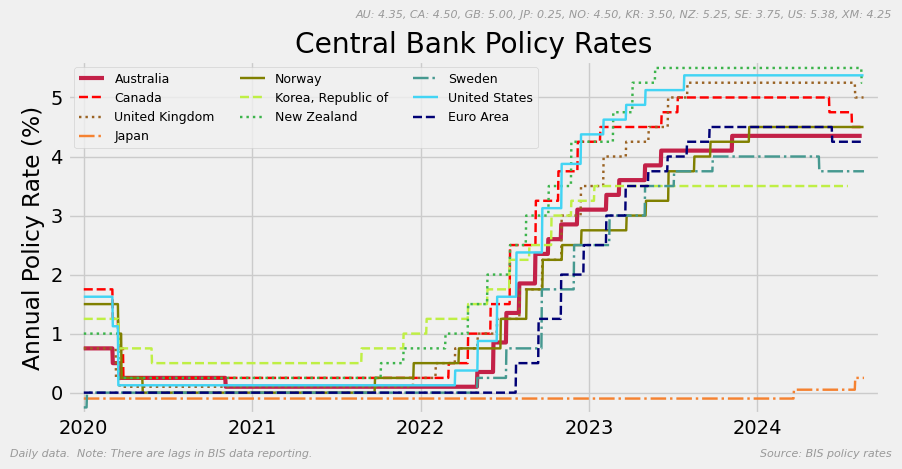

In [83]:
def plot_rates(start="2020-01-01") -> None:
    """Plot the central bank policy rates."""

    line_plot(
        df[lambda x: x.index >= start],
        title="Central Bank Policy Rates",
        ylabel="Annual Policy Rate (%)",
        rfooter=SOURCE,
        lfooter=LFOOTER,
        rheader=latest_rates,
        width=[3] + [1.75] * 20,
        style=["-", "--", ":", "-."] * 5,
        legend={"ncols": 3, "loc": "upper left", "fontsize": 9},
        show=True,
    )


plot_rates()

## The End

In [ ]:
%load_ext watermark
%watermark -u -n -t -v -iv -w